# Introduction

This notebook gives a brief intro to using holoviz-based plotting, incl our own tools that work with it.

To make sure interactivity works correctly, run this notebook in an environment that has all the right stuff installed (i.e., your labcore environment)

## Some basic preliminaries

We assume that `raw` data is in DataDict formats.
For processing and plotting we convert to either `pandas.DataFrame` (for ungridded data) or `xarray.Dataset` (for gridded data).
This approach should be the general way we handle data in the lab.

# Brief primer on vanilla holoviz

We have some tools on top of it for general easy data exploration. 

But for data analysis it's probably very wise for everyone to learn how to use holoviz directly. 
It allows making custom plots extremely easily. 

Docs are here: https://holoviz.org; see in particular ``holoviews`` and `hvplot`.

Here is a very simple example -- we use synthetic Rabi/Chevron data for that.
But much more is possible -- check out the examples in the documentation for how to do different things.

In [9]:
# first, make a dataset in datadict
import numpy as np

from labcore.testing.dispersive_qubit_readout_data import chevron_dataset

raw_data = chevron_dataset(
    Omega_0=1e6,
    Delta_vals=np.linspace(-1e6, 1e6, 11),
    t_vals=np.linspace(0, 3e-6, 25),
    n=500,  # number of shots
)

raw_data

signal: (275, 500)
  ⌙ repetition: (275, 500)
  ⌙ detuning (Hz): (275,)
  ⌙ time (s): (275,)

In [10]:
# next -- convert into xarray. since we know its a nice regular grid, that's the easiest choice here.
from labcore.data.datadict import datadict_to_meshgrid, dd2xr
from labcore.analysis import split_complex

# with the holoviz (or all pydata) tools, complex data isn't always the best, so we split it immediately.
xrdata = split_complex(
    dd2xr(datadict_to_meshgrid(raw_data))
)
xrdata

<xarray.Dataset>
Dimensions:     (repetition: 500, detuning: 11, time: 25)
Coordinates:
  * repetition  (repetition) int64 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500
  * detuning    (detuning) float64 -1e+06 -8e+05 -6e+05 ... 6e+05 8e+05 1e+06
  * time        (time) float64 0.0 1.25e-07 2.5e-07 ... 2.75e-06 2.875e-06 3e-06
Data variables:
    signal_Re   (repetition, detuning, time) float64 0.9181 2.621 ... 2.292
    signal_Im   (repetition, detuning, time) float64 0.531 -0.1323 ... 0.394

In [18]:
# now we can directly use hvplot on this
import hvplot.xarray  # this import patches xarray objects so we can use hvplot on them.

from bokeh.models import CrosshairTool

# plot: average over repetition, then plot the real part as 2d map.
xrdata.signal_Re.mean('repetition').hvplot.quadmesh(
    x='detuning',
    y='time',
)

:QuadMesh   [detuning,time]   (signal_Re)

In [12]:
# it's also pretty easy to make linecuts with sliders
_data = xrdata.mean('repetition')

# here: overlay line and scatter plot
# can change x to get a different cut
_data.hvplot.line(x='time') * _data.hvplot.scatter(x='time')

:DynamicMap   [detuning]
   :Overlay
      .NdOverlay.I  :NdOverlay   [Variable]
         :Curve   [time]   (value)
      .NdOverlay.II :NdOverlay   [Variable]
         :Scatter   [time]   (value)

In [13]:
# looking at readout histograms -- use simply all points in the set
# hexbin is a very simple way to have a quick look at this. 
# doesn't offer too much control, but is 
xrdata.hvplot(
    kind='hexbin',
    aspect=1,
    groupby=[],
    x='signal_Re',
    y='signal_Im',
)

:HexTiles   [signal_Re,signal_Im]

In [14]:
# if we want to select based on some time/detuning values...
xrdata.hvplot(
    kind='hexbin',
    aspect=1,
    groupby=['time', 'detuning'],
    x='signal_Re',
    y='signal_Im',
    xlim=(-3,3),
    ylim=(-3,3)
)

:DynamicMap   [time,detuning]
   :HexTiles   [signal_Re,signal_Im]

# Using our own data exploration tools

## The tldr;

A very simple tool for data exploration exists -- it works almost like plottr, but inside jupyter notebooks.

In [15]:
# a very simple app for exploring typical data
# it has a few issues still -- sometimes it requires going back to setting x and y to None to reset sliders...


from labcore.analysis.plotting.holo import plot_data

plot_data(xrdata.mean('repetition'))

Column
    [0] Column()
    [1] ParamMethod(method, _pane=Column, defer_load=False)

# Prototype

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
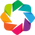

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import param
from param import Parameter, Parameterized
import panel as pn

import holoviews as hv
hv.extension('bokeh')

import hvplot.xarray
import hvplot.pandas

In [8]:
from labcore.data.datadict import DataDict, datadict_to_meshgrid, str2dd, dd2df, dd2xr
from labcore.testing.dispersive_qubit_readout_data import rabi, chevron_dataset
from labcore.analysis import split_complex

raw_data = chevron_dataset(
    Omega_0=1e6,
    Delta_vals=np.linspace(-1e6, 1e6, 11),
    t_vals=np.linspace(0, 3e-6, 25),
    n=500,  # number of shots
)

xrdata = split_complex(
    dd2xr(datadict_to_meshgrid(raw_data))
)
xrdata

<xarray.Dataset>
Dimensions:     (repetition: 500, detuning: 11, time: 25)
Coordinates:
  * repetition  (repetition) int64 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500
  * detuning    (detuning) float64 -1e+06 -8e+05 -6e+05 ... 6e+05 8e+05 1e+06
  * time        (time) float64 0.0 1.25e-07 2.5e-07 ... 2.75e-06 2.875e-06 3e-06
Data variables:
    signal_Re   (repetition, detuning, time) float64 1.374 -0.2951 ... 1.477
    signal_Im   (repetition, detuning, time) float64 -0.05997 1.308 ... -0.1128

## inspect with own app

In [ ]:
from labcore.analysis.plotting.holo import Node, LoaderNode, ValuePlot, ComplexHist

class RabiSimulation(LoaderNode):

    def load_data(self) -> DataDict:
        Omega_0 = 1
        Delta_vals = np.linspace(-2, 2, 41)
        t_vals = np.linspace(0, 3, 31)
        nreps = 50
        dd = chevron_dataset(Omega_0, Delta_vals, t_vals, nreps).expand()
        return dd
    
s = RabiSimulation(name='sim')

app = pn.Column(
    s,
    s.plot,
)
app

In [ ]:
p = ComplexHist(name='testplot', data_in=s.data_out)
p